In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import sys, os, time
from pathlib import Path
from tqdm import tqdm

## 2D dataset

In [2]:
# # The two-dimensional domain of the fit.....
# ########https://scipython.com/blog/non-linear-least-squares-fitting-of-a-two-dimensional-data/#########
# x1min, x1max, nx1 = -5, 6, 75
# x2min, x2max, nx2 = -3, 7, 75
# x1, x2 = np.linspace(x1min, x1max, nx1), np.linspace(x2min, x2max, nx2)
# X1, X2 = np.meshgrid(x1, x2)

# # Our function to fit is going to be a sum of two-dimensional Gaussians
# def gaussian(x1, x2, x10, x20, x1alpha, x2alpha, A):
#     return A * np.exp( -((x1-x10)/x1alpha)**2 -((x2-x20)/x2alpha)**2)

# # A list of the Gaussian parameters: x10, x20, x1alpha, x2alpha, A
# gprms = [(0, 2, 2.5, 5.4, 1.5),
#          (-1, 4, 6, 2.5, 1.8),
#          (-3, -0.5, 1, 2, 4),
#          (3, 0.5, 2, 1, 5)
#         ]

# # Standard deviation of normally-distributed noise to add in generating
# # our test function to fit.
# # The function to be fit is Z.
# Y = np.zeros(X1.shape)
# for p in gprms:
#     Y += gaussian(X1, X2, *p)
# ### Adding noise to the data
# # noise_sigma = 0.1
# # Z += noise_sigma * np.random.randn(*Z.shape)

# ####Scaling the data to range -1,1
# X1 = 2*(X1 - X1.min())/(X1.max() - X1.min()) -1
# X2 = 2*(X2 - X2.min())/(X2.max() - X2.min()) -1
# Y = 2*(Y - Y.min())/(Y.max() - Y.min()) -1
# Y = Y/2

# x1 = X1.reshape(-1)
# x2 = X2.reshape(-1)

# xx = torch.Tensor(np.c_[x1, x2])
# yy = torch.Tensor(Y.reshape(-1,1))

In [3]:
num_points = 50
X1 = np.linspace(-2.5, 1.5, num_points)
# X1 = np.linspace(-2.5, 0, num_points)
X2 = np.linspace(-2, 4, num_points)
# X2 = np.linspace(-2, 2, num_points)
X1, X2 = np.meshgrid(X1, X2)
Y = np.sin(np.sqrt(X1**2 + X2**2))*2-1.

####Scaling the data to range -1,1
X1 = 2*(X1 - X1.min())/(X1.max() - X1.min()) -1
X2 = 2*(X2 - X2.min())/(X2.max() - X2.min()) -1
Y = 2*(Y - Y.min())/(Y.max() - Y.min()) -1
Y = Y

x1 = X1.reshape(-1)
x2 = X2.reshape(-1)

xx = torch.Tensor(np.c_[x1, x2])
yy = torch.Tensor(Y.reshape(-1,1))

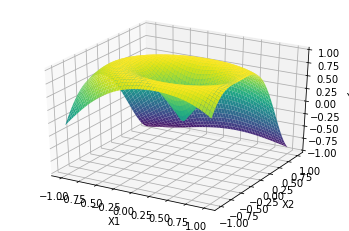

In [4]:
%matplotlib inline
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X1, X2, Y, cmap='viridis')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
plt.show()

### Model Development

In [5]:
def generate_dimension_encoding(dim, binarize=True):
    num_d = int(np.ceil(np.log2(dim)))
#     print(num_d)
    scale = np.arange(0, num_d, 1).reshape(1,-1)
    scale = (1/2)**scale
    
    index = np.arange(0, dim, 1).reshape(-1,1)
#     pos = np.unpackbits(indx.astype()).reshape(-1,8)
    ### target matrix shape is dim, num_d
#     ax = 1/np.arange(0, dim, 1).reshape(-1,1) * scale
#     print(indx_mat.shape)
    mat = index*scale
#     print(1/mat)
#     print(np.sin(mat)**2)
#     pos_mat = np.sin(mat*np.pi/2)**2
#     return torch.Tensor(pos_mat)
    
    if binarize:
        mat = mat*np.pi/2
    sin_mat = np.sin(mat)**2
    cos_mat = np.cos(mat)**2
    pos_mat = np.concatenate((sin_mat, cos_mat), axis=1)
#     print(pos_mat.shape)
    return torch.Tensor(pos_mat)



def generate_dimension_encoding2(dim):
    num_d = int(np.ceil(np.log2(dim)))
    pos_mat = np.empty((dim, num_d))
    for i in range(dim):
        binary = np.binary_repr(i, width=num_d)
        pos_mat[i] = [float(a) for a in binary]
    
    pos_mat = np.concatenate((pos_mat, 1-pos_mat), axis=1)
    return torch.Tensor(pos_mat)


class Layer_DimEncMLP_mul(nn.Module):
    def __init__(self, dim, hidden_ratio = [2], activation=nn.ReLU()):
        super().__init__()
        self.dim = dim
        
        self.pos_mat = generate_dimension_encoding(dim)
#         self.pos_mat = torch.cat((self.pos_mat, torch.ones(dim, 1)), dim=1)
        mlp_inp_dim = self.pos_mat.shape[1]
        la_dims = [mlp_inp_dim]
        for hr in hidden_ratio:
            la_dims.append(int(hr*mlp_inp_dim))
        la_dims.append(1)
        
#         print(la_dims)
        
        layers = []
        for i in range(len(la_dims)-1):
            _a = nn.Linear(la_dims[i], la_dims[i+1])
            layers += [_a, activation]
        layers = layers[:-1]
#         print(layers)
        layers[-1].weight.data *= 0.
        self.net = nn.Sequential(*layers)
        
        self.pos_mat = nn.Parameter(self.pos_mat)
    
#         self.norm = nn.LayerNorm(dim)
        
    def forward(self, x):
#         x = self.norm(x)

#         bs, dim = x.shape
        num_d = self.pos_mat.shape[1]
        encodedX = (x.unsqueeze(dim=2)*self.pos_mat.unsqueeze(dim=0))
#         print(encodedX.shape)
        y = self.net(encodedX.reshape(-1, num_d)).reshape(x.shape)
#         print(y.shape)
        return y


class Layer_DimEncMLP_cat(nn.Module):
    def __init__(self, dim, hidden_ratio = [2], activation=nn.ReLU()):
        super().__init__()
        self.dim = dim
        
        self.pos_mat = generate_dimension_encoding(dim)
        mlp_inp_dim = self.pos_mat.shape[1]
        la_dims = [mlp_inp_dim+1]
        for hr in hidden_ratio:
            la_dims.append(int(hr*mlp_inp_dim))
        la_dims.append(1)
        
        layers = []
        for i in range(len(la_dims)-1):
            _a = nn.Linear(la_dims[i], la_dims[i+1])
            layers += [_a, activation]
        layers = layers[:-1]
        self.net = nn.Sequential(*layers)
        
        self.pos_mat = nn.Parameter(self.pos_mat)
    
#         self.norm = nn.LayerNorm(dim)
        
    def forward(self, x):
#         x = self.norm(x)
        
        num_d = self.pos_mat.shape[1]
        encodedX = torch.cat([\
                              x.unsqueeze(dim=2),\
                              self.pos_mat.expand(x.shape[0], *self.pos_mat.shape)\
                             ],\
                             dim=2)
        y = self.net(encodedX.reshape(-1, num_d+1)).reshape(x.shape)
        return y
    
    
class Layer_DimEncMLP_add(nn.Module):
    def __init__(self, dim, hidden_ratio = [2], activation=nn.ReLU()):
        super().__init__()
        self.dim = dim
        
        self.pos_mat = generate_dimension_encoding(dim)
#         self.pos_mat = torch.cat((self.pos_mat, torch.ones(dim, 1)), dim=1)
        self.pos_mat = self.pos_mat*2-1
        mlp_inp_dim = self.pos_mat.shape[1]
        la_dims = [mlp_inp_dim]
        for hr in hidden_ratio:
            la_dims.append(int(hr*mlp_inp_dim))
        la_dims.append(1)
        
#         print(la_dims)
        
        layers = []
        for i in range(len(la_dims)-1):
            _a = nn.Linear(la_dims[i], la_dims[i+1])
            layers += [_a, activation]
        layers = layers[:-1]
#         print(layers)
        self.net = nn.Sequential(*layers)
        self.pos_mat = nn.Parameter(self.pos_mat)
    
#         self.norm = nn.LayerNorm(dim)
        
    def forward(self, x):
#         x = self.norm(x)

#         bs, dim = x.shape
        num_d = self.pos_mat.shape[1]
        encodedX = (x.unsqueeze(dim=2)+self.pos_mat.unsqueeze(dim=0))
#         print(encodedX.shape)
        y = self.net(encodedX.reshape(-1, num_d)).reshape(x.shape)
#         print(y.shape)
        return y

In [6]:
# X = torch.randn(1,2)
# pos_mat = generate_dimension_encoding2(2)
# pos_mat

In [7]:
# num_d = pos_mat.shape[1]
# encodedX = (xx.unsqueeze(dim=2)+pos_mat.unsqueeze(dim=0))

In [27]:
class MLP_0(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(2, 10) ## 35
        self.l2 = nn.LeakyReLU()
        self.l3 = nn.Linear(10, 10)
        self.l4 = nn.LeakyReLU()
        self.l5 = nn.Linear(10, 1)
        
    def forward(self, x):
        x = self.l1(x)
        x = self.l2(x)
        x = self.l3(x)
        x = self.l4(x)
        x = self.l5(x)
        return x
    
class MLP_1(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(2, 4)
#         self.l3 = nn.Linear(10, 10)
        self.l5 = nn.Linear(4, 1)
        self.l2 = Layer_DimEncMLP_add(4, [2,2], activation=nn.SELU())
#         self.l4 = Layer_DimEncMLP_cat(10, [2,2], activation=nn.LeakyReLU())
        
    def forward(self, x):
        x = self.l1(x)
        res = self.l2(x)
        x = x+res
#         x = self.l3(x)
#         res = self.l4(x)
#         x = x+res
        x = self.l5(x)
        return x
    


In [28]:
X = torch.randn(5,2)

In [29]:
MLP_1()(X).shape

torch.Size([5, 1])

### Model Training

In [30]:
torch.manual_seed(0)
# model = MLP_0()
model = MLP_1()
print("number of params: ", sum(p.numel() for p in model.parameters()))

number of params:  154


In [31]:
# model.l2.pos_mat.shape

In [32]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [33]:
## MLP1: number of params:  474
## MLP0: number of params:  476

print("number of params: ", sum(p.numel() for p in model.parameters()))

number of params:  154


Epoch: 0, Loss:0.4133593738079071
Epoch: 100, Loss:0.1427774727344513
Epoch: 200, Loss:0.11864505708217621
Epoch: 300, Loss:0.09413155913352966
Epoch: 400, Loss:0.0528353750705719
Epoch: 500, Loss:0.0346507765352726
Epoch: 600, Loss:0.031435612589120865
Epoch: 700, Loss:0.028220465406775475
Epoch: 800, Loss:0.026018381118774414
Epoch: 900, Loss:0.024596303701400757
Epoch: 1000, Loss:0.02349921315908432
Epoch: 1100, Loss:0.022429225966334343
Epoch: 1200, Loss:0.02113000676035881
Epoch: 1300, Loss:0.019488640129566193
Epoch: 1400, Loss:0.017876047641038895
Epoch: 1500, Loss:0.016201049089431763
Epoch: 1600, Loss:0.014082792215049267
Epoch: 1700, Loss:0.011216218583285809
Epoch: 1800, Loss:0.00736752524971962
Epoch: 1900, Loss:0.004978395998477936
Epoch: 2000, Loss:0.004335335455834866
Epoch: 2100, Loss:0.003969260491430759
Epoch: 2200, Loss:0.003817768767476082
Epoch: 2300, Loss:0.0037011399399489164
Epoch: 2400, Loss:0.003604109166190028
Epoch: 2500, Loss:0.0035223846789449453
Epoch: 26

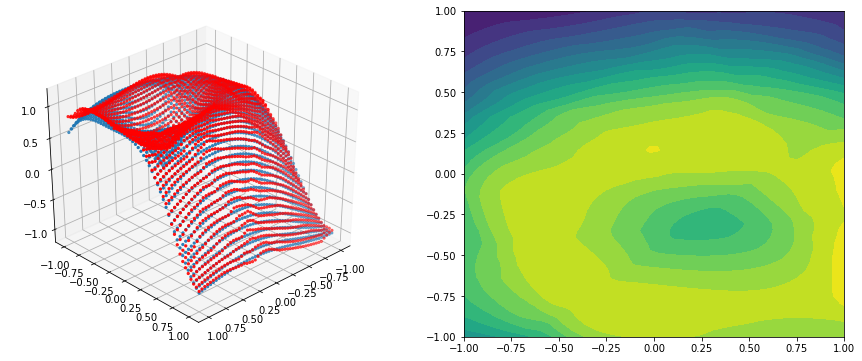

In [34]:
EPOCHS = 5000

%matplotlib  tk
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(121,projection='3d')
ax2 = fig.add_subplot(122)

for epoch in range(EPOCHS):
        yout = model(xx)    
        loss = criterion(yout, yy)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch%100 == 0:
            print(f'Epoch: {epoch}, Loss:{float(loss)}')

            ax.clear()
            ax.scatter(X1, X2, yy.data.numpy().reshape(-1), marker= '.')
            ax.scatter(X1, X2, yout.data.numpy().reshape(-1), color='r', marker='.')

            ax2.clear()
            ax2.contourf(X1, X2, yout.data.numpy().reshape(Y.shape), levels=20)

            fig.canvas.draw()
            plt.pause(0.01)

In [16]:
### number of params:  267780, 267920
## MLP_1, cat Epoch: 3900, Loss:0.00036122131859883666
### cat, Epoch: 4900, Loss:0.011388302780687809  number of params:  146 

## MLP_0, Epoch: 3900, Loss:0.00038901326479390264
### Epoch: 4900, Loss:0.00186129508074373  np 


## Visualize first activations

In [35]:
### inputs from -1, 1 for every dimension in a batch
X = torch.linspace(-5, 5, steps=20).expand(model.l2.dim, -1).transpose(0,1)
X.shape

torch.Size([20, 4])

In [36]:
model = model.eval()
ys = model.l2(X).data.cpu()
ys.shape

torch.Size([20, 4])

In [37]:
ys

tensor([[ 7.6745,  4.6862,  4.8608,  2.1248],
        [ 7.0794,  3.6935,  4.1578,  1.1926],
        [ 6.4837,  2.7681,  3.4223,  0.2846],
        [ 5.8898,  1.8970,  2.6445, -0.5823],
        [ 5.3014,  1.0963,  1.8109, -1.3800],
        [ 4.7244,  0.3913,  0.8961, -2.0738],
        [ 4.1666, -0.1711, -0.1725, -2.5855],
        [ 3.6324, -0.5810, -1.6634, -2.9515],
        [ 3.0892, -0.6177, -4.3664, -2.9092],
        [ 2.2154, -0.9474, -5.0351, -1.8391],
        [ 0.5813,  2.0963, -4.8319,  0.1161],
        [ 0.5369,  4.3312, -5.0349,  3.5464],
        [ 0.6351,  5.5212, -4.0577,  5.6573],
        [ 1.9023,  6.5985, -2.6819,  6.8383],
        [ 3.2425,  7.6440, -1.1497,  7.9191],
        [ 4.6053,  8.6721,  0.4261,  8.9752],
        [ 5.8112,  9.6873,  1.6963, 10.0187],
        [ 6.9301, 10.6920,  2.8713, 11.0529],
        [ 7.9954, 11.6876,  3.9874, 12.0792],
        [ 9.0227, 12.6750,  5.0649, 13.0985]])

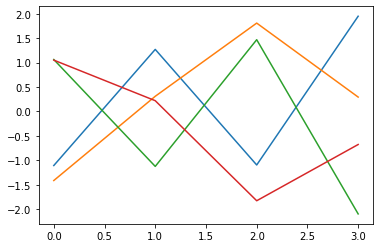

In [38]:
%matplotlib inline
plt.plot(model.l2.pos_mat.data)

In [39]:
model.l2

Layer_DimEncMLP_add(
  (net): Sequential(
    (0): Linear(in_features=4, out_features=8, bias=True)
    (1): SELU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): SELU()
    (4): Linear(in_features=8, out_features=1, bias=True)
  )
)

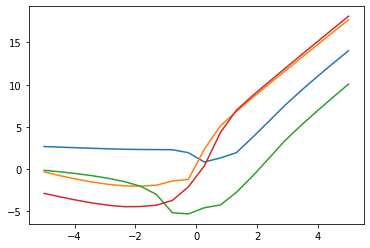

In [40]:
%matplotlib inline

num_show = 10
for i in range(model.l2.dim):
    plt.plot(X[:,i], ys[:,i]+X[:,i])
    if (i+1)%num_show == 0:
#         plt.axis("equal")
        plt.show()

In [22]:
# model = MLP_1()
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# print("number of params: ", sum(p.numel() for p in model.parameters()))

In [23]:
# EPOCHS = 15
# steps_ = 0
# for epoch in range(EPOCHS):
#     train_acc = 0
#     train_count = 0
#     for index in range(train_size // batch_size):
#         steps_ += 1

#         train_x = train_data[index * batch_size:(index + 1) * batch_size]
#         train_y = train_label[index * batch_size:(index + 1) * batch_size]

#         yout = model(train_x)
#         loss = criterion(yout, train_y)
        
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         if steps_%500==0:
#             print('\nTRAIN',epoch, steps_, '-> ', float(loss))
# #             yout = model.forward(train_data)
# #             outputs = tnn.Logits.logit_to_index(yout)
# #             correct = (outputs == np.array(train_label_)).sum()

# #             accuracy = correct / len(train_label_) * 100.
# #             print('EPOCH = ','accuracy = ', accuracy)
# #             print(correct, '/', len(train_label_))
            
#             with torch.no_grad():
#                 yout = model(test_data)
#             outputs = tnn.Logits.logit_to_index(yout.cpu().numpy())
#             correct = (outputs == np.array(test_label_)).sum()

#             accuracy = correct / len(test_label_) * 100.
#             print('   TEST  ','accuracy = ', accuracy)
#             print(correct, '/', len(test_label_))       

In [24]:
# model.l2.pos_mat

In [25]:
np.log2(128)

7.0